## Train the yolo model
The model is deployed using FastAPI as microservice to an internal Kuberntes cluster

In [3]:
import base64
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
import random
import numpy as np
import cv2
import requests
import os
import shutil
import tensorflow as tf
# from tensorflow.keras.preprocessing import image 
import seaborn as sns
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif')
import torch
import sys
import pandas as pd
sys.path.insert(1, "yolov5")
from io import BytesIO
from utils.plots import plot_results 
import json
%matplotlib inline

## Training

Modified the data/coco128.yml as below

path: ../pool  # dataset root dir
train: images/train  # train images (relative to 'path') 128 images
val: images/valid  # val images (relative to 'path') 128 images
test:  # test images (optional)

nc: 1  # number of classes
names: [ 'swimming pool' ]  # class names

### Results

The MAP at an IOU of 50% is close 0.92 which is a decent result. I shall this use the best model for inference

In [4]:
# !python ./yolov5/train.py --img 640 --batch 8 --epochs 50

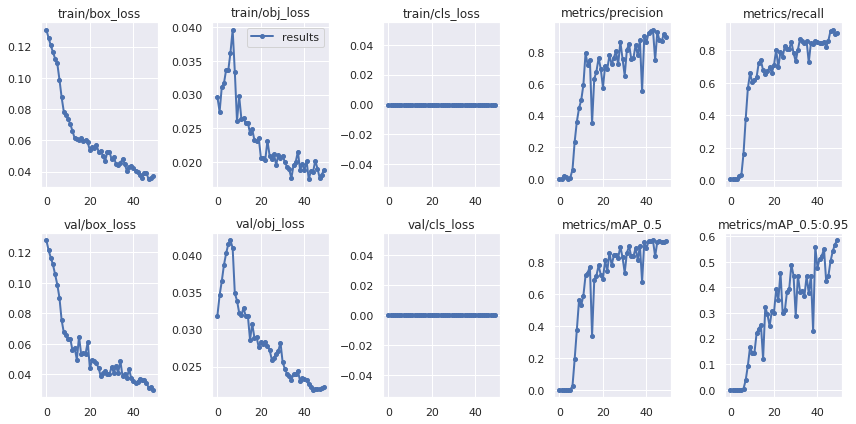

In [5]:
plot_results('yolov5/runs/train/exp2/results.csv')

In [12]:
results = pd.read_csv("yolov5/runs/train/exp2/results.csv")
results[['               epoch', '      train/box_loss', '      train/obj_loss',
       '      train/cls_loss', '   metrics/precision', '      metrics/recall',
       '     metrics/mAP_0.5', 'metrics/mAP_0.5:0.95']].tail()

,epoch,train/box_loss,train/obj_loss,train/cls_loss,metrics/precision,metrics/recall,metrics/mAP_0.5,metrics/mAP_0.5:0.95
45,45,0.038901,0.020186,0,0.92759,0.85926,0.92509,0.44357
46,46,0.039126,0.019019,0,0.87278,0.92030,0.93132,0.50194
47,47,0.035156,0.017656,0,0.86853,0.92646,0.92336,0.54037
48,48,0.035787,0.018096,0,0.91358,0.90241,0.92375,0.56720
49,49,0.037231,0.018862,0,0.89721,0.90854,0.92926,0.58342


## Inference

### Torch inference 
Use the local weights file

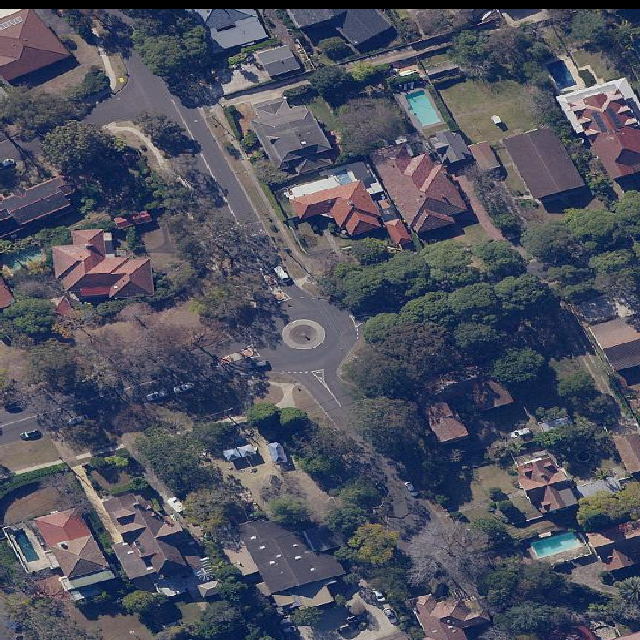

In [13]:
image = Image.open("pool/images/valid/merged-gordon-19_151.146_-33.758.tif")
image

In [15]:
# load the weights file
model = torch.hub.load('yolov5', 'custom', path="yolov5/runs/train/exp2/weights/best.pt", source='local')
result = model(image)
result.print()

YOLOv5 🚀 v5.0-321-g5d66e48 torch 1.9.0+cu102 CUDA:0 (NVIDIA TITAN V, 12066.6875MB)

Fusing layers... 
Model Summary: 224 layers, 7053910 parameters, 0 gradients, 16.3 GFLOPs
Adding AutoShape... 
image 1/1: 640x640 6 swimming pools
Speed: 1.5ms pre-process, 6.6ms inference, 1.0ms NMS per image at shape (1, 3, 640, 640)


In [16]:
json_string = result.pandas().xyxy[0].to_json(orient="records")
json_result = json.loads(json_string) 
for result in json_result:
    print(result)

{'xmin': 404.5, 'ymin': 86.125, 'xmax': 441.0, 'ymax': 125.0, 'confidence': 0.8442382812, 'class': 0, 'name': 'swimming pool'}
{'xmin': 529.0, 'ymin': 530.5, 'xmax': 579.0, 'ymax': 558.5, 'confidence': 0.7993164062, 'class': 0, 'name': 'swimming pool'}
{'xmin': 13.0390625, 'ymin': 528.5, 'xmax': 39.71875, 'ymax': 563.5, 'confidence': 0.7758789062, 'class': 0, 'name': 'swimming pool'}
{'xmin': 547.0, 'ymin': 57.4375, 'xmax': 576.0, 'ymax': 89.5625, 'confidence': 0.7270507812, 'class': 0, 'name': 'swimming pool'}
{'xmin': 1.765625, 'ymin': 244.625, 'xmax': 42.875, 'ymax': 272.5, 'confidence': 0.6977539062, 'class': 0, 'name': 'swimming pool'}
{'xmin': 334.0, 'ymin': 170.0, 'xmax': 354.5, 'ymax': 183.75, 'confidence': 0.3774414062, 'class': 0, 'name': 'swimming pool'}


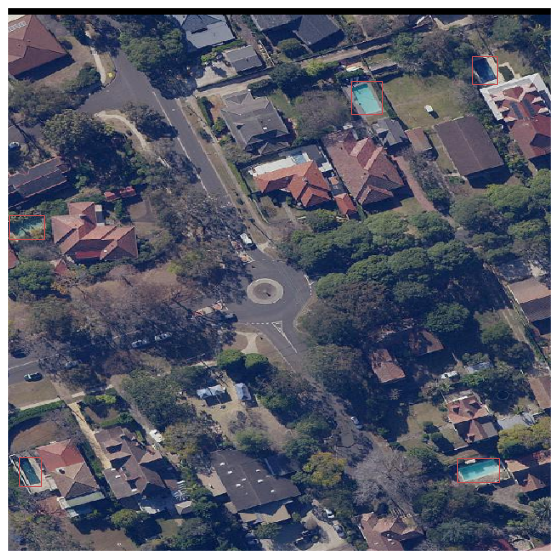

In [18]:
# plot the detetced bounding boxes of pools

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.xticks([])
plt.yticks([])
ax.imshow(image);
for result in json_result:
    if result['confidence'] > 0.5:
        x = result['xmin']
        y = result['ymin']
        width = (result['xmax'] - result['xmin'])
        height = (result['ymax'] - result['ymin'])
        plt.gca().add_patch(Rectangle((x, y), width, height,
                                      linewidth=1, edgecolor='r', facecolor='none'))

### Try the deployed rest API end point

The API end point is http://10.34.74.11:32711/detect

1. The micro service is deployed as a pod to a kubernbetes cluster. Note that it is deployed to an internal network hence inaccessible without a VPN.

2. The deployed microservice takes close 30 seconds for inference. This is terrible and can be attributed to the size of the image which is around 1.2 MB in size. In practice this can be reduced by using other formats such as jpeg which are much smaller in size.

In [19]:
# read the image as a base64 encoded string and send to the micro-service
with open("pool/images/valid/near_burwood_151.09_-33.886.tif", "rb") as f:
    im_b64 = base64.b64encode(f.read()).decode()

im_bytes = base64.b64decode(im_b64)   # im_bytes is a binary image
im_file = BytesIO(im_bytes)  # convert image to file-like object
img = Image.open(im_file)   # img is now PIL Image object

In [20]:
headers = {"content-type": "application/json"}
data = json.dumps({"im_b64": im_b64})

In [21]:
resp= requests.post("http://10.34.74.11:32711/detect",
                    data=data, headers=headers)
print(resp.elapsed.total_seconds())

28.037426


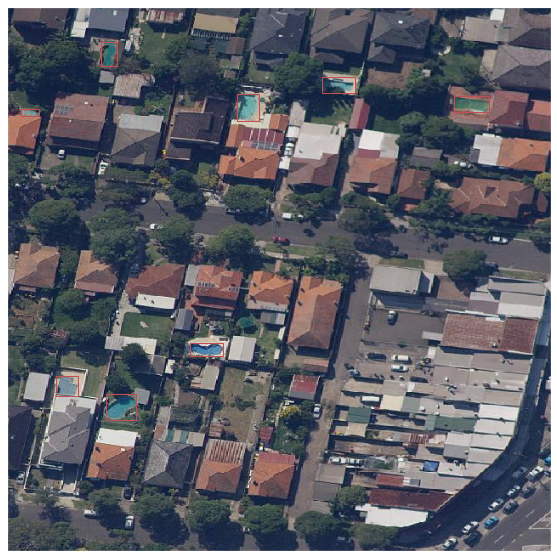

In [22]:
# verify the result
json_result = json.loads(resp.text)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.xticks([])
plt.yticks([])
ax.imshow(img);
for result in json_result:
    if result['confidence'] > 0.5:
        x = result['xmin']
        y = result['ymin']
        width = (result['xmax'] - result['xmin'])
        height = (result['ymax'] - result['ymin'])
        plt.gca().add_patch(Rectangle((x, y), width, height,
                                      linewidth=1, edgecolor='r', facecolor='none'))